# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [2]:
# %%pycodestyle
class MyKmeans:

    def __init__(self,
                 k=2,
                 metric='euclidean',
                 max_iter=1000,
                 random_state=None,
                 init='random',
                 eps=0.001
                 ):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.metric = metric
        self.labels = None
        self.centroids = None
        self.inertia_ = None
        self.eps = eps

    def fit(self, X, count_inertia=False):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self._init_centroids(self.init, X)
        dist = np.empty((self.k, X.shape[0]))

        tmp_intervals = np.max(X, axis=0) - np.min(X, axis=0)

        for _ in range(self.max_iter):

            if self.metric == 'euclidean':
                for i in range(self.k):
                    dist[i] = self._euclidean(X, self.centroids[i])
            else:
                assert 'metric not Implemented'

            self.labels = np.argmin(dist, axis=0)
            dif = np.empty(self.k)
            for i in range(self.k):
                k_labels = (self.labels == i)
                tmp = np.mean(X[k_labels, :], axis=0)
                dif[i] = (np.abs(self.centroids[i] - tmp) /
                          tmp_intervals
                          ).sum()
                self.centroids[i] = tmp
            dif /= X.shape[1]
            if np.all(dif <= self.eps):
                break

        if count_inertia:
            self.inertia_ = 0
            for i in range(self.k):
                tmp = np.abs(X[self.labels == i] - self.centroids[i])
                self.inertia_ += (tmp * tmp).sum()

        return self

    def predict(self, X):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dist = np.empty((self.k, X.shape[0]))
        if self.metric == 'euclidean':
            for i in range(self.k):
                dist[i] = self._euclidean(X, self.centroids[i])
        else:
            assert 'metric not Implemeted'
        return np.argmin(dist, axis=0)

    def _init_centroids(self, method, X):

        if method == 'random':
            centroids_indicies = np.random.choice(np.arange(X.shape[0]),
                                                  size=self.k,
                                                  replace=False
                                                  )
            self.centroids = X[centroids_indicies]

        elif method == 'k-means++':

            self.centroids[0, :] = X[np.random.randint(low=0, high=X.shape[0])]
            dist = np.zeros((self.k, X.shape[0]))
            for i in range(1, self.k):
                for j in range(i):
                    dist[j] = self._euclidean(X, self.centroids[j])
                min_dist = np.min(dist[:i, :], axis=0)
                sum_ = min_dist.sum()
                centr_sum = np.random.uniform(0, sum_)
                sums = np.cumsum(min_dist)
                self.centroids[i, :] = X[sums > centr_sum][0]
        else:
            assert 'init not Implemented'

    @staticmethod
    def _euclidean(X, centroid):
        tmp = X - centroid
        return (tmp * tmp).sum(axis=1)


class MiniBatchKMeans(MyKmeans):
    def __init__(self,
                 k=2,
                 metric='euclidean',
                 max_iter=1000,
                 random_state=None,
                 init='random',
                 batch_size=0.4,
                 eps=1
                 ):
        super().__init__(k,
                         metric,
                         max_iter,
                         random_state,
                         init,
                         eps=eps
                         )
        self.batch_size = batch_size

    def fit(self, X, count_inertia=False):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        super()._init_centroids(self.init, X)

        batch_sz = int(X.shape[0] * self.batch_size)
        dist = np.empty((self.k, batch_sz))

        tmp_intervals = np.max(X, axis=0) - np.min(X, axis=0)
        tmp_counter = np.zeros(self.k)

        for j in range(self.max_iter):
            batch = np.random.randint(low=0, high=X.shape[0], size=batch_sz)
            if self.metric == 'euclidean':
                for i in range(self.k):
                    dist[i] = super()._euclidean(X[batch], self.centroids[i])
            else:
                assert 'metric not Implemented'

            tmp_labels = np.argmin(dist, axis=0)
            dif = np.zeros(self.k)

            for i in range(self.k):
                k_labels = (tmp_labels == i)
                if k_labels.sum() > 2:
                    tmp_counter[i] += 1
                    rate = 1 / tmp_counter[i]
                    tmp = (1 - rate) * self.centroids[i] +\
                        rate * np.mean(X[batch][k_labels], axis=0)
                    dif[i] = (np.abs(self.centroids[i] - tmp) / tmp_intervals).sum()
                    self.centroids[i] = tmp
            dif /= X.shape[1]
            if np.all(dif < self.eps):
                break

        dist = np.empty((self.k, X.shape[0]))
        for i in range(self.k):
            dist[i] = super()._euclidean(X, self.centroids[i])
        self.labels = np.argmin(dist, axis=0)

        if count_inertia:
            self.inertia_ = 0
            for i in range(self.k):
                tmp = np.abs(X[self.labels == i] - self.centroids[i])
                self.inertia_ += (tmp * tmp).sum()
        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [52]:
from sklearn.datasets import make_blobs

In [53]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

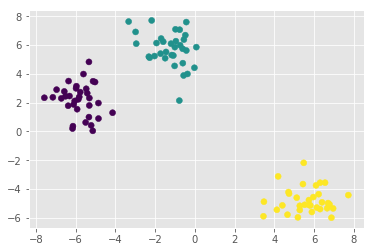

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [55]:
from sklearn.cluster import KMeans

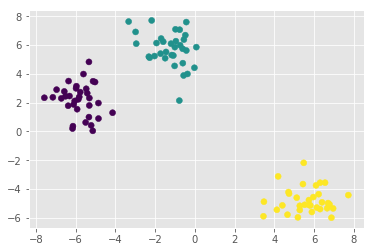

In [56]:
## Работоспособность MyKmeans
model = MyKmeans(k=3,
                 random_state=10,
                 init='random',
                 eps=0.1
                 )
model.fit(X)
pred = model.predict(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=pred)

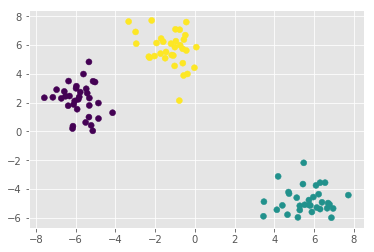

In [57]:
## Работоспособность MyKmeans++
model = MyKmeans(k=3,
                 random_state=10,
                 init='k-means++',
                 eps=0.1
                 )
model.fit(X)
pred = model.predict(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=pred)

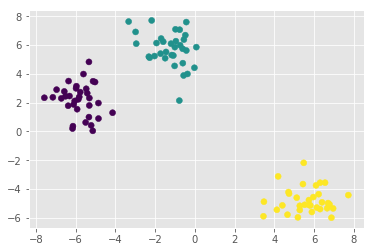

In [58]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3,
                        random_state=10,
                        batch_size=0.4,
                        init='random',
                        eps=0.1
                        )
model.fit(X)
pred = model.predict(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=pred)

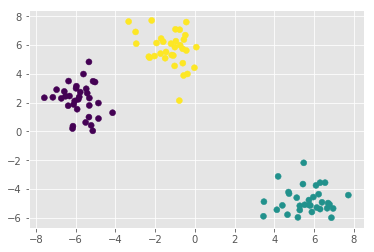

In [59]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
model = MiniBatchKMeans(k=3,
                        random_state=10,
                        batch_size=0.4,
                        init='k-means++',
                        eps=0.1
                        )
model.fit(X)
pred = model.predict(X)
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=pred)

In [60]:
model = KMeans(n_clusters=3,
               init='random',
               precompute_distances=False,
               max_iter=1000,
               n_init=1,
               random_state=10,
               )

In [61]:
%%timeit
## Время выполнения алгоритма Kmeans из sklearn
model.fit(X)

1.61 ms ± 2.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
model = MyKmeans(k=3,
                 random_state=10,
                 init='random',
                 max_iter=1000,
                 eps=0.1
                 )

In [63]:
%%timeit
## Время выполнения алгоритма MyKmeans
model.fit(X)

469 µs ± 4.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [64]:
model = MyKmeans(k=3,
                 random_state=10,
                 init='k-means++',
                 max_iter=1000,
                 eps=0.1
                 )

In [65]:
%%timeit
## Время выполнения алгоритма MyKmeans++
model.fit(X)

388 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [66]:
model = MiniBatchKMeans(k=3,
                        random_state=10,
                        init='random',
                        max_iter=1000,
                        batch_size=0.4,
                        eps=0.1
                        )

In [67]:
%%timeit
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
model.fit(X)

711 µs ± 2.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [68]:
model = MiniBatchKMeans(k=3,
                        random_state=10,
                        init='k-means++',
                        max_iter=0,
                        batch_size=0.4,
                        eps=0.1
                        )

In [69]:
%%timeit
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
model.fit(X)

169 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [70]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [71]:
df_sns = df_sns.drop(columns=['gradyear', 'gender', 'age', 'friends'])

In [72]:
df_sns.shape

(30000, 36)

In [73]:
X = np.array(df_sns)
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [88]:
# %%pycodestyle
def interpret_clust(X, centroids, labels):

    fields = df_sns.columns
    for i in range(9):
        plt.figure()
        dif = centroids[i, :]
        title = str((labels == i).sum()) + ' - cluster size \n' +\
            'признаки с отклонением больше чем на 0.5 от 0: \n'
        for i in range(dif.size):
            if dif[i] > 0.5:
                title += fields[i] + '\n'
        plt.title(title)
        plt.scatter(np.arange(X.shape[1]), dif)

    mx_clust = np.argmax(np.unique(labels, return_counts=True)[1])
    plt.figure()
    dif = centroids[mx_clust, :]
    title = str((labels == mx_clust).sum()) + ' - cluster size \n' +\
        'наибольший кластер \n' +\
        'признаки с отклонением больше чем на 0.1 от 0: \n'
    for i in range(dif.size):
        if dif[i] < -0.1:
            title += fields[i] + '\n'
    plt.title(title)
    plt.scatter(np.arange(X.shape[1]), dif)

In [75]:
%%time
## MyKMeans
model = MyKmeans(k=9,
                 random_state=10,
                 init='random',
                 max_iter=1000
                 )
model.fit(X, count_inertia=True)
print(model.inertia_)

872766.8481719398
CPU times: user 2.26 s, sys: 4.14 ms, total: 2.27 s
Wall time: 2.27 s


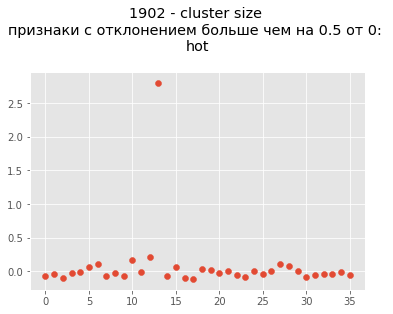

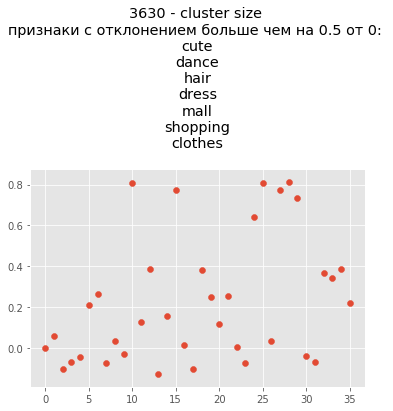

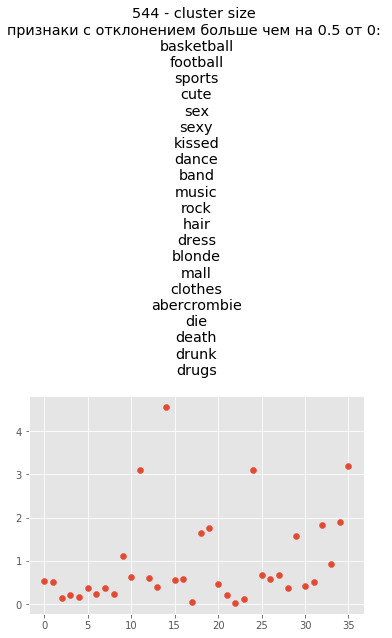

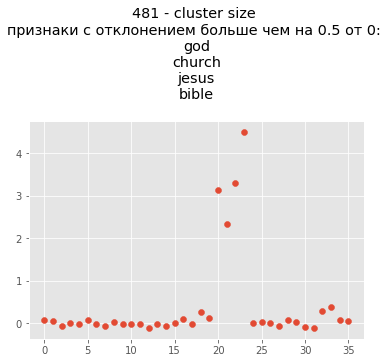

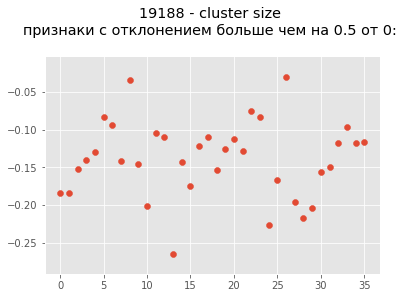

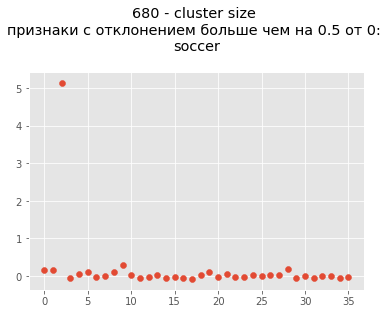

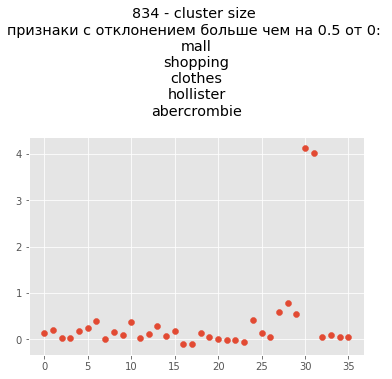

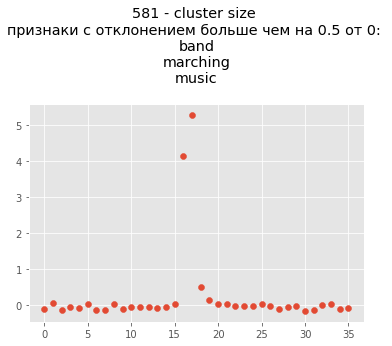

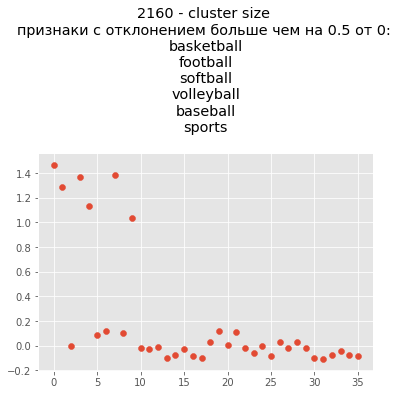

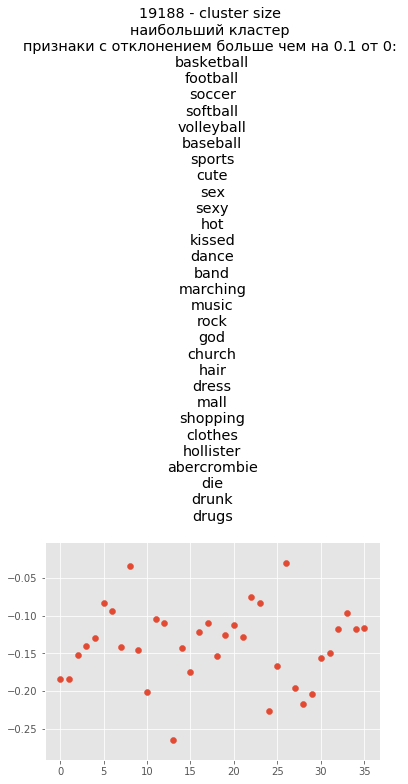

In [76]:
interpret_clust(X, model.centroids, model.labels)

In [77]:
%%time
## MyKMeans++
model = MyKmeans(k=9,
                 random_state=10,
                 init='k-means++',
                 max_iter=1000
                 )
model.fit(X, count_inertia=True)
print(model.inertia_)

882392.015980545
CPU times: user 953 ms, sys: 272 µs, total: 953 ms
Wall time: 950 ms


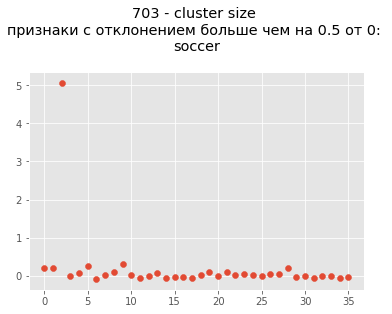

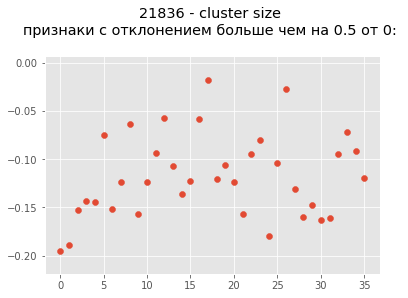

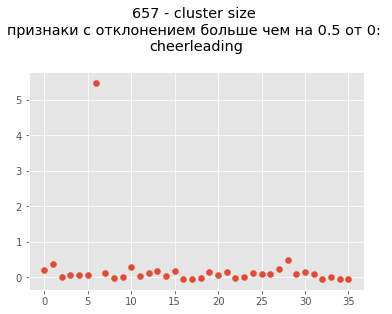

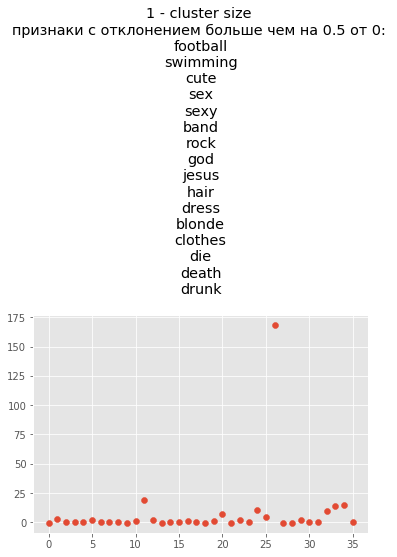

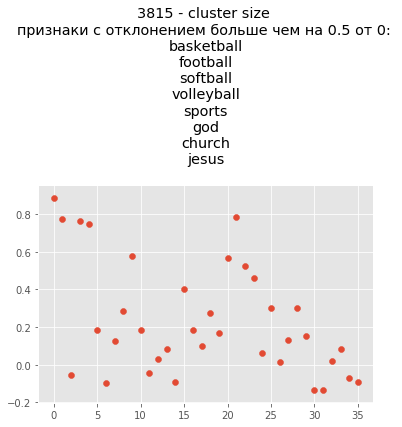

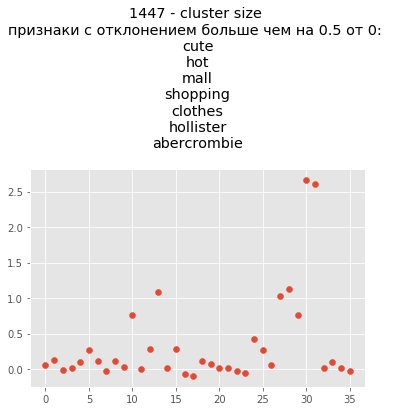

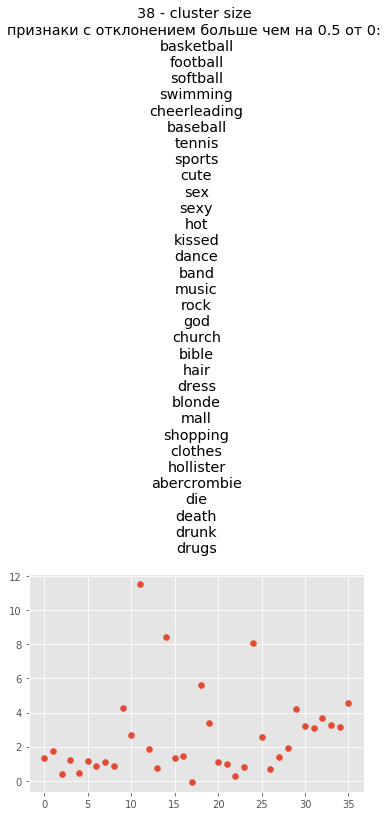

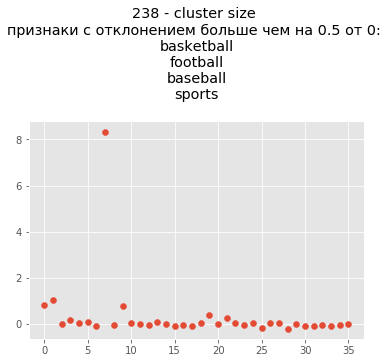

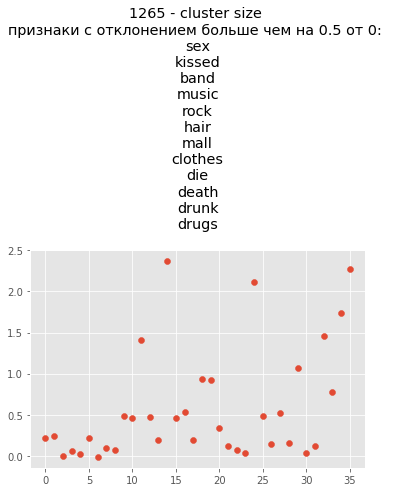

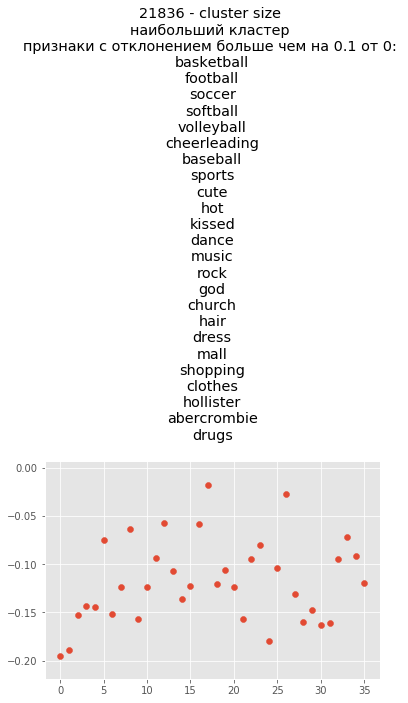

In [78]:
interpret_clust(X, model.centroids, model.labels)

In [79]:
%%time
## MyKMeans с MiniBatchMyKMeans
model = MiniBatchKMeans(k=9,
                        random_state=10,
                        init='random',
                        max_iter=1000,
                        batch_size=0.3,
                        eps=0.001
                        )
model.fit(X, count_inertia=True)
print(model.inertia_)

899825.7796619168
CPU times: user 1.23 s, sys: 46 µs, total: 1.23 s
Wall time: 1.22 s


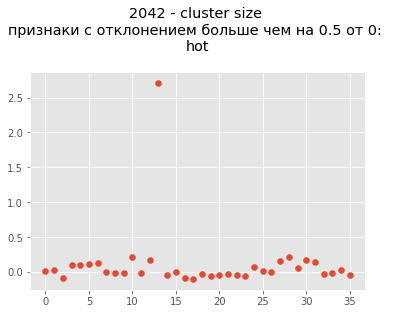

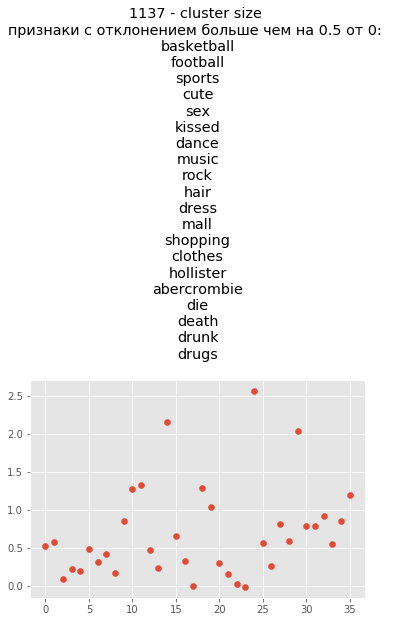

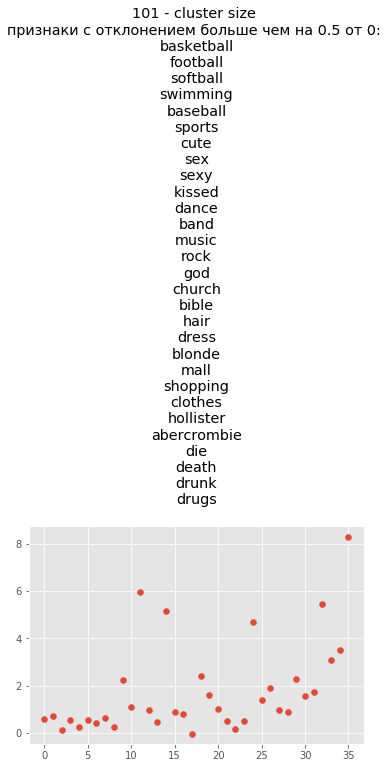

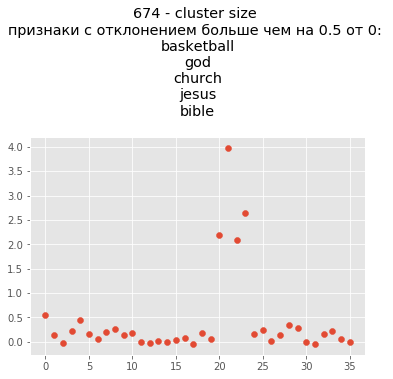

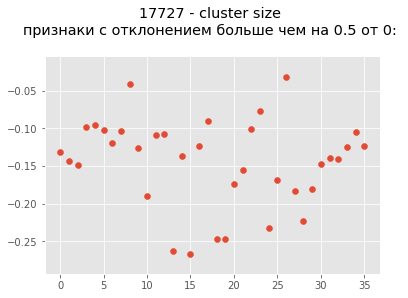

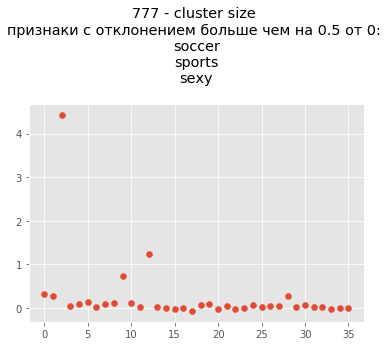

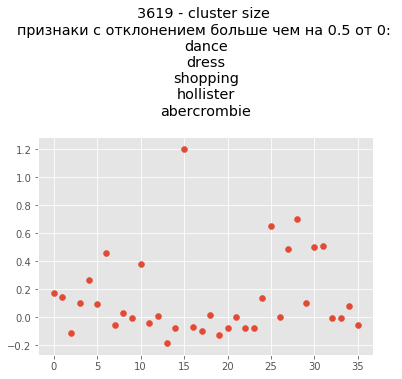

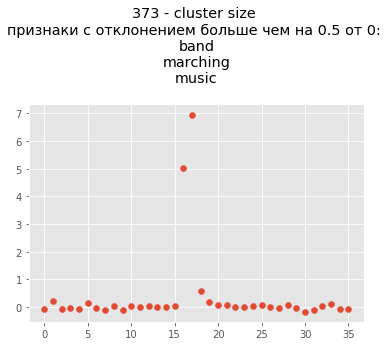

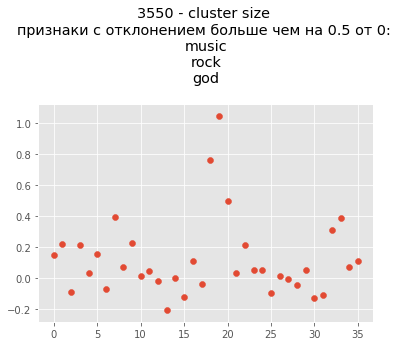

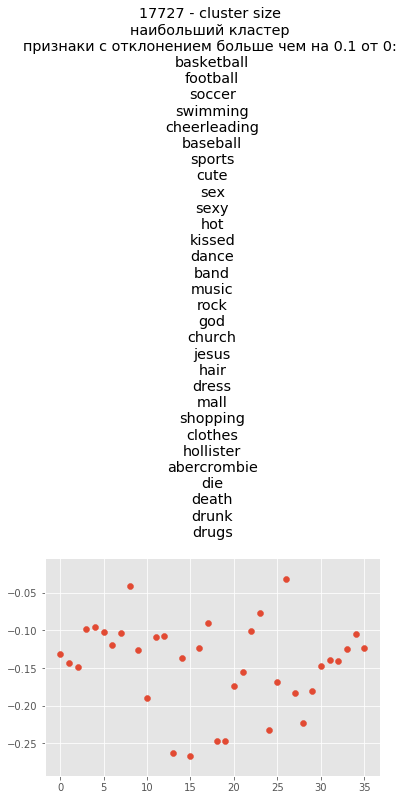

In [80]:
interpret_clust(X, model.centroids, model.labels)

In [81]:
%%time
## MyKMeans++ с MiniBatchMyKMeans
model = MiniBatchKMeans(k=9,
                        random_state=10,
                        init='k-means++',
                        max_iter=1000,
                        batch_size=0.3,
                        eps=0.001
                        )
model.fit(X, count_inertia=True)
print(model.inertia_)

895965.1333899965
CPU times: user 2.74 s, sys: 8.13 ms, total: 2.75 s
Wall time: 2.74 s


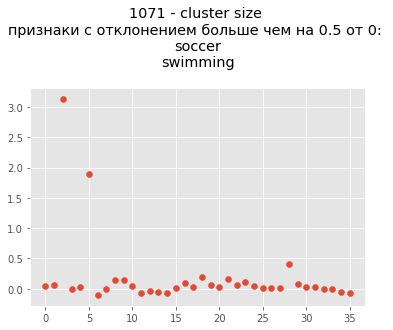

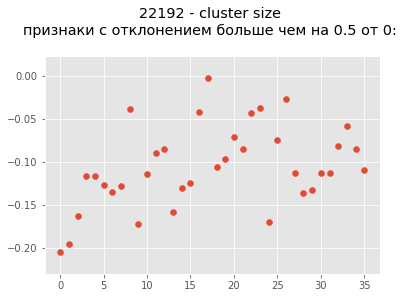

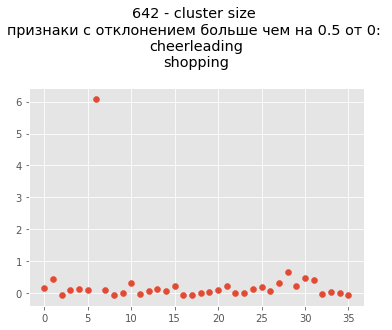

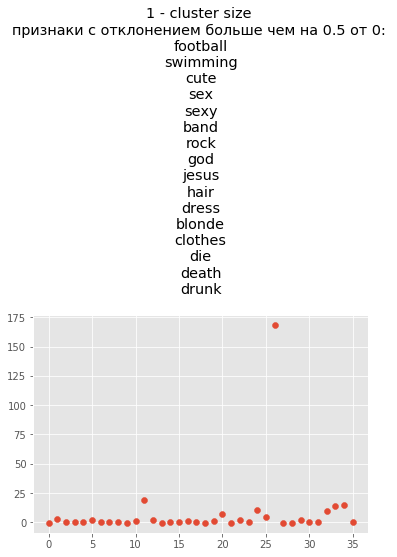

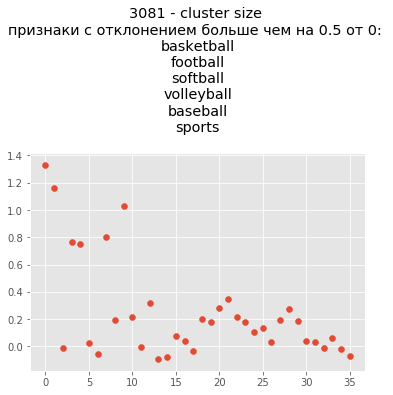

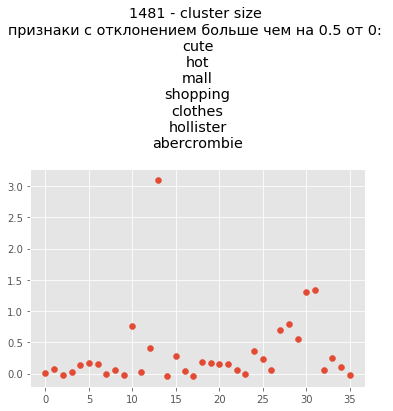

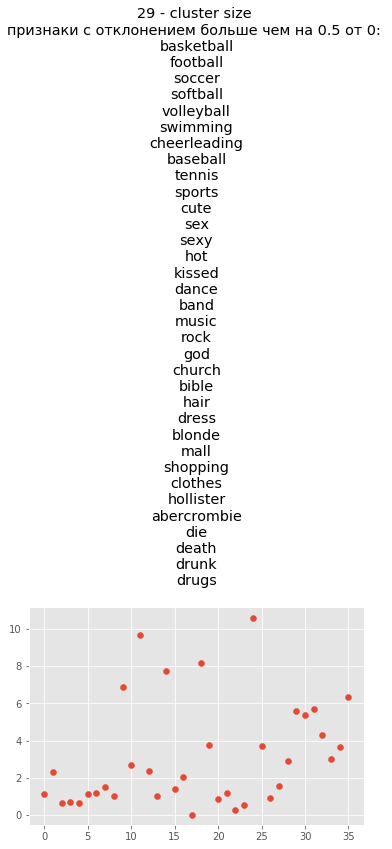

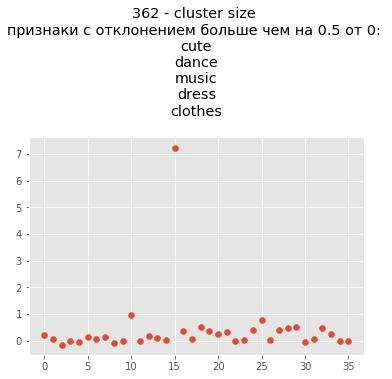

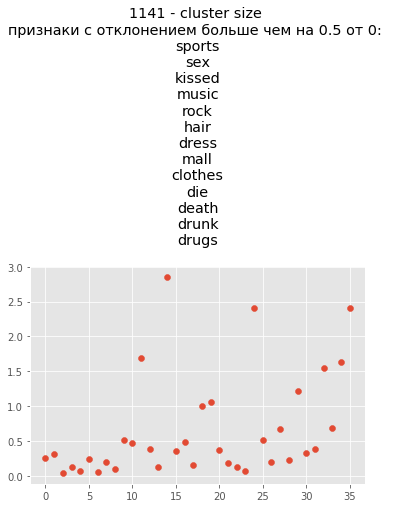

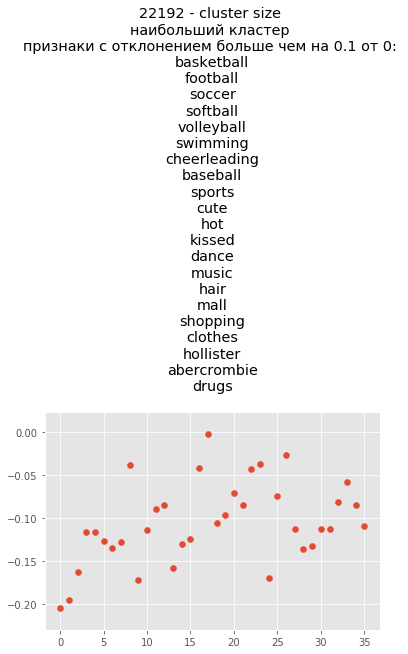

In [82]:
interpret_clust(X, model.centroids, model.labels)

In [ ]:
## Вывод
k-means++ инициализация выдаёт более точное приближение центроид кластеров при инициализации,
и таким образом может либо просто ускорять сходимость, либо не ускорять, но менять точность, 
если алгоритм с random инициализацией останавливается в локальном минимуме (верхние 2 клетки)

Одна итерация MiniBatchKmeans работает быстрее одной итерации Kmeans, но сходится медленнее,
из-за этого заметно теряется точность, имеет смысл его использовать, если эта потеря не критична.
Работает быстрее в силу того, что рассчёт новых положений центроид ведётся по части датасета.

Вывод вывода: Качество и скорость работы алгоритмов кластеризации зависит от кластеризуемых данных,
но в среднем minibatch алгоритмы быстрее обычных, но теряют точность,
kmeans++ инициализация ускоряет работу алгоритмов